# 7.　線形回帰
# 7. Linear regression

In [1]:
# 必要ライブラリの宣言
# Import required libralies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# waring抑止
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 「ボストン・データセット」はscikit-learnのライブラリでも取得できるが、
# その場合、将来版で利用できなくなる予定のため、別Webサイトから取得する
# Download boston dataset not from scikit-learn libraries but from web site to keep downloadable

## Get boston dataset 
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(
    data_url, 
    sep="\s+",      # "\s+" means "separate with spaces"
    skiprows=22,    # 22 rows are explanation 
    header=None)
print(raw_df)

             0      1      2    3      4      5     6       7    8      9   \
0       0.00632  18.00   2.31  0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1     396.90000   4.98  24.00  NaN    NaN    NaN   NaN     NaN  NaN    NaN   
2       0.02731   0.00   7.07  0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
3     396.90000   9.14  21.60  NaN    NaN    NaN   NaN     NaN  NaN    NaN   
4       0.02729   0.00   7.07  0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
...         ...    ...    ...  ...    ...    ...   ...     ...  ...    ...   
1007  396.90000   5.64  23.90  NaN    NaN    NaN   NaN     NaN  NaN    NaN   
1008    0.10959   0.00  11.93  0.0  0.573  6.794  89.3  2.3889  1.0  273.0   
1009  393.45000   6.48  22.00  NaN    NaN    NaN   NaN     NaN  NaN    NaN   
1010    0.04741   0.00  11.93  0.0  0.573  6.030  80.8  2.5050  1.0  273.0   
1011  396.90000   7.88  11.90  NaN    NaN    NaN   NaN     NaN  NaN    NaN   

        10  
0     15.3  
1      NaN  
2     17.8  
3      NaN 

リンク先のボストンデータセットは、11colomn目で改行されているので、２行で14colomnとなる。

The linked Boston dataset has a line break at the 11th colomn, so there are 14 colomns in two lines.

１行目の全要素と2行目の3列までの要素を抽出し繋げる加工が必要。

Processing is required to extract and connect all elements in the first row and up to three columns in the second row.

priceは14番目の数字になる。

price is the 14th number.

In [3]:
##  Process data
## [Rows(Start:Stop:Step), colomns]
x_org = np.hstack([raw_df.values[::2, :],   ## Extract every second element from the whole row
    raw_df.values[1::2, :2]])               ## Extract every second element from the one line to the last line, and extract up to third row
yt = raw_df.values[1::2, 2]                 ## Get price
feature_names = np.array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX',
    'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO','B', 'LSTAT'])

## Show data details
print('元データ', x_org.shape, yt.shape)
print('項目名: ', feature_names)

# データ絞り込み (項目 RMのみ)
# Get RM data
x_data = x_org[:,feature_names == 'RM']
print('絞り込み後', x_data.shape)

# ダミー変数を追加
# Add dummy variable
x = np.insert(x_data, 0, 1.0, axis=1)   ## insert(original data, position of insert value, value, 0:row/1:column)
print('ダミー変数追加後', x.shape)

元データ (506, 13) (506,)
項目名:  ['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']
絞り込み後 (506, 1)
ダミー変数追加後 (506, 2)


In [4]:
# 入力データxの表示 (ダミー変数を含む)
# Show input data x including dummy variable
print(x.shape)
print(x[:5,:])

(506, 2)
[[1.    6.575]
 [1.    6.421]
 [1.    7.185]
 [1.    6.998]
 [1.    7.147]]


In [5]:
# 正解データ yの表示
# Show true data y
print(yt[:5])

[24.  21.6 34.7 33.4 36.2]


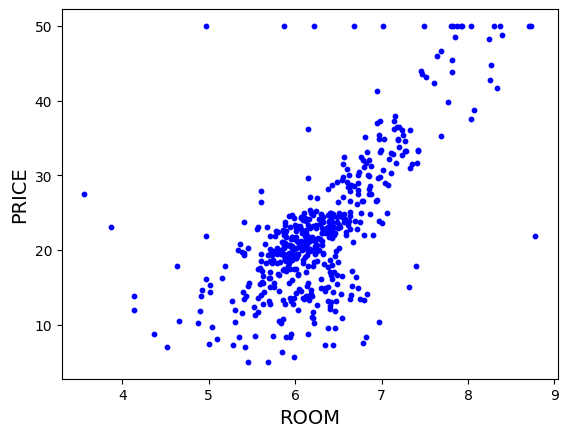

In [6]:
# 散布図の表示
# Show scatter plot
plt.scatter(x[:,1], yt, s=10, c='b')
plt.xlabel('ROOM', fontsize=14)
plt.ylabel('PRICE', fontsize=14)
plt.show()

In [7]:
# 予測関数 (1, x)の値から予測値ypを計算する
# Calculate predinction value yp from the value of prediction function (1. x)
def pred(x, w):
    return(x @ w)

In [8]:
# 初期化処理
# Initialization process

# データ系列総数
# Total number of data series
M  = x.shape[0]
print(M)

# 入力データ次元数(ダミー変数を含む)
# Number of dimensions of input data including dummy variable
D = x.shape[1]
print(D)

# 繰り返し回数
# Number of repetitions
iters = 50000

# 学習率
# Learning rate
alpha = 0.01

# 重みベクトルの初期値 (すべての値を1にする)
# Initial value of weight vector (set 1 to all value)
w = np.ones(D)
print(w)

# 評価結果記録用 (損失関数値のみ記録)
# For recording evaluation results (recording only the value of loss function) 
history = np.zeros((0,2))  ## matrix 0x2

506
2
[1. 1.]


### Reference

```math
yp^{(k)(m)} = w^{(k)} * x^{(m)}    \qquad    (7.8.1)
```

```math
yd^{(k)(m)} = yp^{(k)(m)} - yt^{(m)}    \qquad    (7.8.2)
```

```math
w^{(k+1)} = w^{(k)} - \frac{\alpha}{M}\sum_{m=0}^{M-1}yd^{(k)(m)}*x^{(m)}   \qquad    (7.8.4)
```

```math
L(w_0, w_1) = \frac{1}{2M}\sum_{m=0}^{M-1}(yp^{(m)} - yt^{(m)})^{2}  \qquad    (7.6.1)
```

In [9]:
# 繰り返しループ
# repeat loop
for k in range(iters):
    
    # 予測値の計算 (7.8.1)
    # Calculating prediction value
    yp = pred(x, w)
    
    # 誤差の計算 (7.8.2)
    # Calculating the error
    yd = yp - yt
    
    # 勾配降下法の実装 (7.8.4)
    # Implementation of gradient descent
    w = w - alpha * (x.T @ yd) / M
    
    # 学習曲線描画用データの計算、保存
    # Calculating and saving the data of learning curve for drawing
    if ( k % 100 == 0):
        # 損失関数値の計算 (7.6.1)
        # Calculating the value of loss function
        loss = np.mean(yd ** 2) / 2
        # 計算結果の記録
        # Recording the result of calculation
        history = np.vstack((history, np.array([k, loss])))
        # 画面表示
        # Show results
        print( "iter = %d  loss = %f" % (k, loss))    

iter = 0  loss = 154.224934
iter = 100  loss = 29.617518
iter = 200  loss = 29.431766
iter = 300  loss = 29.250428
iter = 400  loss = 29.073399
iter = 500  loss = 28.900577
iter = 600  loss = 28.731861
iter = 700  loss = 28.567154
iter = 800  loss = 28.406360
iter = 900  loss = 28.249388
iter = 1000  loss = 28.096145
iter = 1100  loss = 27.946544
iter = 1200  loss = 27.800498
iter = 1300  loss = 27.657922
iter = 1400  loss = 27.518733
iter = 1500  loss = 27.382852
iter = 1600  loss = 27.250200
iter = 1700  loss = 27.120700
iter = 1800  loss = 26.994277
iter = 1900  loss = 26.870858
iter = 2000  loss = 26.750372
iter = 2100  loss = 26.632749
iter = 2200  loss = 26.517921
iter = 2300  loss = 26.405821
iter = 2400  loss = 26.296385
iter = 2500  loss = 26.189549
iter = 2600  loss = 26.085252
iter = 2700  loss = 25.983433
iter = 2800  loss = 25.884034
iter = 2900  loss = 25.786997
iter = 3000  loss = 25.692265
iter = 3100  loss = 25.599784
iter = 3200  loss = 25.509501
iter = 3300  loss = 2

In [10]:
# 最終的な損失関数初期値、最終値
# Final loss function initial value, final value
print('損失関数初期値: %f' % history[0,1])
print('損失関数最終値: %f' % history[-1,1])

損失関数初期値: 154.224934
損失関数最終値: 21.800325


In [11]:
# 下記直線描画用の座標値計算
# Coordinate value calculation for drawing the straight line below
xall = x[:,1].ravel()
xl = np.array([[1, xall.min()],[1, xall.max()]])
yl = pred(xl, w)

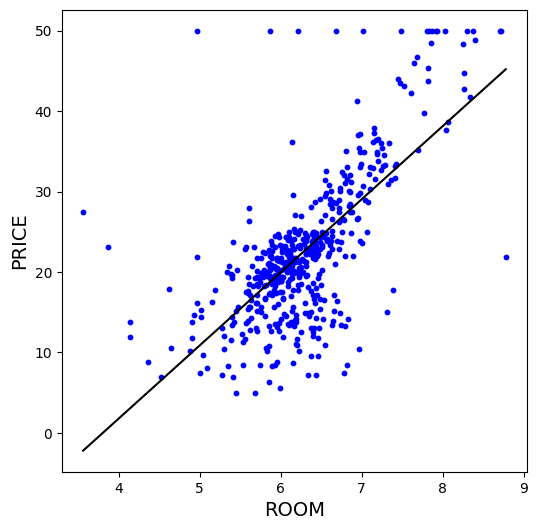

In [12]:
# 散布図と回帰直線の描画
# Drawing scatter plot and regression line
plt.figure(figsize=(6,6))
plt.scatter(x[:,1], yt, s=10, c='b')
plt.xlabel('ROOM', fontsize=14)
plt.ylabel('PRICE', fontsize=14)
plt.plot(xl[:,1], yl, c='k')
plt.show()

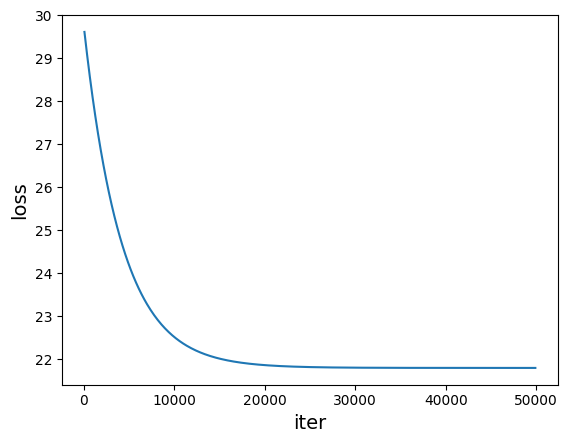

In [13]:
# 学習曲線の表示 (最初の1個分を除く)
# Show lerning curve (except for the first one)
plt.plot(history[1:,0], history[1:,1])
plt.xlabel('iter', fontsize=14)
plt.ylabel('loss', fontsize=14)
plt.show()

## 7.10  重回帰モデルへの拡張
## 7.10  Extension to multiple regression models

In [14]:
# 列(LSTAT: 低所得者率)の追加
# Add column for LSTAT: Low income rate
x_add = x_org[:,feature_names == 'LSTAT']
x2 = np.hstack((x, x_add))
print(x2.shape)

(506, 3)


In [15]:
# 入力データxの表示 (ダミーデータを含む)
# Show input data x including dummy data
print(x2[:5,:])

[[1.    6.575 4.98 ]
 [1.    6.421 9.14 ]
 [1.    7.185 4.03 ]
 [1.    6.998 2.94 ]
 [1.    7.147 5.33 ]]


In [16]:
# 初期化処理
# Initializing process

# データ系列総数
# Total number of data series
M  = x2.shape[0]

# 入力データ次元数(ダミー変数を含む)
# Number of dimensions of input data including dummy variable
D = x2.shape[1]

# 繰り返し回数
# Number of repeatitions
iters = 50000

# 学習率
# Learning rate
alpha = 0.01

# 重みベクトルの初期値 (すべての値を1にする)
# Initial value of waight vector (set 1 to all value)
w = np.ones(D)

# 評価結果記録用 (損失関数値のみ記録)
# For recording evaluation results (recording only the value of loss function) 
history = np.zeros((0,2))

### Reference

```math
yp^{(k)(m)} = w^{(k)} * x^{(m)}    \qquad    (7.8.1)
```

```math
yd^{(k)(m)} = yp^{(k)(m)} - yt^{(m)}    \qquad    (7.8.2)
```

```math
w^{(k+1)} = w^{(k)} - \frac{\alpha}{M}\sum_{m=0}^{M-1}yd^{(k)(m)}*x^{(m)}   \qquad    (7.8.4)
```

```math
L(w_0, w_1) = \frac{1}{2M}\sum_{m=0}^{M-1}(yp^{(m)} - yt^{(m)})^{2}  \qquad    (7.6.1)
```

In [17]:
# 繰り返しループ
# Repeat loop
for k in range(iters):
    
    # 予測値の計算 (7.8.1)
    # Calculating prediction value
    yp = pred(x2, w)
    
    # 誤差の計算 (7.8.2)
    # Calculating error
    yd = yp - yt
    
    # 勾配降下法の実装 (7.8.4)
    # Implementation of gradient decent
    w = w - alpha * (x2.T @ yd) / M
    
    # 学習曲線描画用データの計算、保存
    # Calclating and saving the data of learnig rate for drawing
    if ( k % 100 == 0):
        # 損失関数値の計算 (7.6.1)
        # Calculating the value of loss function
        loss = np.mean(yd ** 2) / 2
        # 計算結果の記録
        # Recording the results of calculations
        history = np.vstack((history, np.array([k, loss])))
        # 画面表示
        # Show results
        print( "iter = %d  loss = %f" % (k, loss))    

iter = 0  loss = 112.063982
iter = 100  loss = 3753823486849654538960539484160.000000
iter = 200  loss = 2655334090092048840304997303457399619333641481694889411346432.000000
iter = 300  loss = 1878297995285389845771871419740313448531353246802527452461280621621659241714209067974524928.000000
iter = 400  loss = 1328647635059328515131961917958233260010110874734494815182181913568993750919607000530712562926733207758140202205197631488.000000
iter = 500  loss = 939842635502848959802051905083333893189693285496059755389148058019690357736842983091667264575645792135994156419976659397682157829724819024732452028416.000000
iter = 600  loss = 664814474659043143721802884115979632987110146028734825208170044266817116202120531605157962210827793933144596617956699525450809534261818804738123510745485935010887781352757771894784.000000
iter = 700  loss = 4702683928354687184978187890654866672969122171181106574526728253801155702466042964976465215954654704241742146146156203615235119947571438894045866602442630883

In [18]:
# 初期化処理 (パラメータを適切な値に変更)
# Initializing process (change to appropiriate value)

# データ系列総数
# Total number of data series
M  = x2.shape[0]

# 入力データ次元数(ダミー変数を含む)
# Number of dimensions of input data including dummy variable
D = x2.shape[1]

# 繰り返し回数
# Number of repetitions
#iters = 50000
iters = 2000

# 学習率
# Learning rate
#alpha = 0.01
alpha = 0.001

# 重みベクトルの初期値 (すべての値を1にする)
# Initial value of weight vector (Set 1 to all value)
w = np.ones(D)

# 評価結果記録用 (損失関数値のみ記録)
# For recording the evaluation results (recording only the value of loss function)
history = np.zeros((0,2))

### Reference

```math
yp^{(k)(m)} = w^{(k)} * x^{(m)}    \qquad    (7.8.1)
```

```math
yd^{(k)(m)} = yp^{(k)(m)} - yt^{(m)}    \qquad    (7.8.2)
```

```math
w^{(k+1)} = w^{(k)} - \frac{\alpha}{M}\sum_{m=0}^{M-1}yd^{(k)(m)}*x^{(m)}   \qquad    (7.8.4)
```

```math
L(w_0, w_1) = \frac{1}{2M}\sum_{m=0}^{M-1}(yp^{(m)} - yt^{(m)})^{2}  \qquad    (7.6.1)
```

In [19]:
# 繰り返しループ
# Repeat loop
for k in range(iters):
    
    # 予測値の計算 (7.8.1)
    # Calculating prediction value
    yp = pred(x2, w)
    
    # 誤差の計算 (7.8.2)
    # Calculating error
    yd = yp - yt
    
    # 勾配降下法の実装 (7.8.4)
    # Implementation of gradient decent
    w = w - alpha * (x2.T @ yd) / M
    
    # 学習曲線描画用データの計算、保存
    # Calculating and saving the data of learning rate for drawing
    if ( k % 100 == 0):
        # 損失関数値の計算 (7.6.1)
        # Calculating the value of loss function
        loss = np.mean(yd ** 2) / 2
        # 計算結果の記録
        # Recording the results of calculations
        history = np.vstack((history, np.array([k, loss])))
        # 画面表示
        # Show results
        print( "iter = %d  loss = %f" % (k, loss))    

iter = 0  loss = 112.063982
iter = 100  loss = 25.358934
iter = 200  loss = 16.391055
iter = 300  loss = 15.403015
iter = 400  loss = 15.294135
iter = 500  loss = 15.282114
iter = 600  loss = 15.280764
iter = 700  loss = 15.280589
iter = 800  loss = 15.280544
iter = 900  loss = 15.280514
iter = 1000  loss = 15.280485
iter = 1100  loss = 15.280456
iter = 1200  loss = 15.280428
iter = 1300  loss = 15.280399
iter = 1400  loss = 15.280371
iter = 1500  loss = 15.280342
iter = 1600  loss = 15.280314
iter = 1700  loss = 15.280285
iter = 1800  loss = 15.280257
iter = 1900  loss = 15.280228


In [20]:
# 最終的な損失関数初期値、最終値
# Final loss function initial value, final value
print('損失関数初期値: %f' % history[0,1])
print('損失関数最終値: %f' % history[-1,1])

損失関数初期値: 112.063982
損失関数最終値: 15.280228


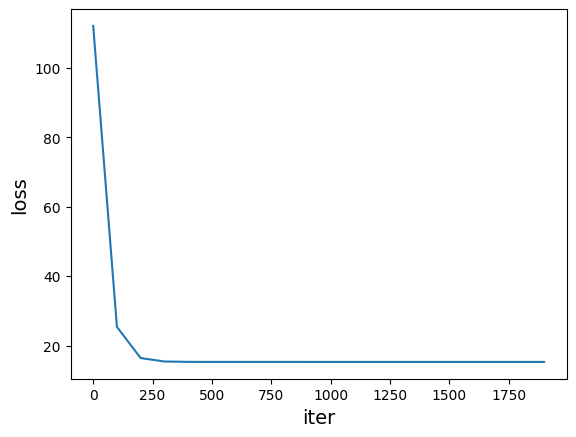

In [21]:
# 学習曲線の表示 (最初の10個分を除く)
# Show learning curve (except for the first ten pieces)
plt.plot(history[:,0], history[:,1])
plt.xlabel('iter', fontsize=14)
plt.ylabel('loss', fontsize=14)
plt.show()

# コラム. Numpyを使ったコーディングテクニック
# Column. Coding technic using Numpy

##  ベクトル・ベクトル間の内積
## Inner product between vectors

In [22]:
# w = (1, 2)
w = np.array([1, 2])
print(w)
print(w.shape)

[1 2]
(2,)


In [23]:
# x = (3, 4)
x = np.array([3, 4])
print(x)
print(x.shape)

[3 4]
(2,)


In [24]:
# (3.7.2)式の内積の実装例
# Example of inner product of (3.7.2)

# y = 1*3 + 2*4 = 11
y = x @ w
print(y)

11


## 行列・ベクトル間の内積
## Inner product between matrix and vector

In [25]:
# X は3行2列の行列
# X is a 3-by-2 matrix
X = np.array([[1,2],[3,4],[5,6]])
print(X)
print(X.shape)

[[1 2]
 [3 4]
 [5 6]]
(3, 2)


In [26]:
Y = X @ w
print(Y)
print(Y.shape)

[ 5 11 17]
(3,)


## データ系列方向の行列・ベクトル間の内積
## Inner product between matrices and vectors in the data series direction

In [27]:
# 転置行列の作成
# Creating a transposed matrix
XT = X . T
print(X)
print(XT)

[[1 2]
 [3 4]
 [5 6]]
[[1 3 5]
 [2 4 6]]


In [28]:
yd = np.array([1, 2, 3])
print(yd)

[1 2 3]


In [29]:
# 勾配値の計算(の一部)
# Gradient value calculation (part of)
grad = XT @ yd
print(grad)

[22 28]
